# Week VI - The Ising model (Part I)

Today, we will discuss a possible implementation of the **2D Ising model on a square lattice**. In particular, we will consider a system in equilibrium with a thermal bath, such that the temperature is constant. Temporal evolution will be simulated through the **spin flip dynamics** in periodic boundary conditions (PBC).

We will study the model by monitoring the following quantities:
* spin magnetisation 
    $$\frac{M}{N}  = \frac{1}{N}\sum_i s_i$$
* energy 
    $$\frac{E}{N} = \frac{1}{N}\sum_{NN(i,j)} s_i$$
* heat capacity
    $$c = \frac{<E^2>-<E>^2}{k_BT^2N}$$
* magnetic susceptibility
    $$\chi = \frac{<M^2>-<M>^2}{k_BTN}$$

In the following we will set $k_B=1$ and $J=1$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Ising:
    '''
    This class implements 
    the 2D Ising model
    on a square lattice in PBCs
    '''
    
    def __init__(self,L,T,N_equi,N_mcs,sample_equi=False,data_filename='data.txt'):
        'Initialise the Ising model'
        self.L = L
        self.N = L**2
        self.T = T
        self.M = None
        self.M_N = None
        self.E = None
        self.E_N = None
        self.E_N_av = None
        self.M_N_av = None
        self.rng = np.random.default_rng(seed=42424)
        self.spin = np.zeros((L,L),dtype=np.int32)
        self.w_dict = {}
        self.acc = 0
        self.counter = 0
        self.N_equi = N_equi
        self.N_mcs = N_mcs
        self.data = []
        self.ar = None
        self.var = None
        self.sample_equi = sample_equi
        self.c_heat = None
        self.chi_mag = None
        self.autocorr = []
        self.n_autocorr = 10
        self.data_filename = data_filename 
    
    def make_pm(self,x):
        '''
        Convert random uniform array
        into array of -1 and +1
        '''
        def tmp(x):
            if x<0.5:
                return 1
            else:
                return -1
        f = np.frompyfunc(tmp, 1, 1)
        return f(x)
    
    def get_up_right(self,i,j):
        '''
        PBCs up/right
        '''
        if j==(self.L-1):
            up = 0
        else:
            up = j+1
        if i==(self.L-1):
            right = 0
        else:
            right = i+1
            
        return up,right
    
    def get_down_left(self,i,j):
        '''
        PBCs down/left
        '''
        if j==0:
            down = self.L-1
        else:
            down = j-1
        if i==0:
            left = self.L-1
        else:
            left = i-1
            
        return down,left
    
    def calc_energy(self):
        '''
        Calculates the total energy.
        NB: this is used only at initialization.
        '''
        E = 0
        for j in range(self.L):
            for i in range(self.L):
                up,right = self.get_up_right(i,j)
                E = E - self.spin[i,j]*(self.spin[i,up]+self.spin[right,j])
        return E
                       
    def deltaE(self,i,j):
        '''
        Calculates change in energy for the spin flip
        '''
        up,right = self.get_up_right(i,j)
        down,left = self.get_down_left(i,j)
        res = 2.0*self.spin[i,j]*(self.spin[i,up]+self.spin[i,down]+self.spin[left,j]+self.spin[right,j])
        return (res,int(res))
    
    def initialize(self):
        '''
        Initialization of the system:
        -spins are randomly configured
        -energy is calculated from scratch
        -dictionary with Metropolis' probability
        coefficents is created
        '''
        r = self.rng.random((self.L,self.L))
        self.spin = self.make_pm(r)
        self.M = np.sum(self.spin)
        self.M_N = self.M/float(self.N)
        self.E = self.calc_energy()
        self.E_N = self.E/float(self.N)
        for dE in range(-8,8+1,4):
            self.w_dict[dE] = np.exp(-1.0*dE/self.T)
    
    def metro_step(self):
        'One step of Metropolis spin flip dynamics'
        for ispin in range(self.N):
            (ii,jj) = self.rng.integers(0,high=self.L,size=2)
            dE,dE_int = self.deltaE(ii,jj)
            rnd_w = self.rng.random()
            if (rnd_w<=self.w_dict[dE_int]):
                self.spin[ii,jj] = -1*self.spin[ii,jj]
                self.acc += 1
                self.M = self.M + 2* self.spin[ii,jj]
                self.M_N = self.M/float(self.N)
                self.E = self.E + dE
                self.E_N = self.E/float(self.N)
    

    def metro_driver(self,N_step,store=True):
        'Run N Metropolis steps of spin flip dynamics'
        for i in range(N_step):
            self.counter += self.N
            self.metro_step()
            if store:
                self.data.append((self.E,self.M))            
            
    def ising_driver(self):
        '''
        Main driver for the Monte Carlo
        '''
        self.initialize()
        self.metro_driver(self.N_equi,store=self.sample_equi)
        self.metro_driver(self.N_mcs)
        self.data = np.array(self.data)
        np.savetxt(self.data_filename,self.data)
    
    @staticmethod
    def plot_spin(spin):
        x,y = np.meshgrid(range(spin.shape[0]),range(spin.shape[1]))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.scatter(x,y,c=spin[x,y],label='spin')
        plt.title('spin configuration')
        plt.colorbar()
        plt.show()
    
    @staticmethod
    def calc_autocorr(a,N):
        'Autocorrelation function'
        res = np.ones(N)
        for k in range(1,N):
            c_k = np.average(a[:-k]*a[k:]) 
            x_r = np.average(a[:-k])
            x_r_2 = np.average(a[:-k]**2)
            res[k] = (c_k-x_r**2)/(x_r_2-x_r**2)
        return res
    
    def get_stats(self):
        '''
        Calculate, store and print 
        statistical quantities
        '''
        self.ar = self.acc*1.0/self.counter
        self.E_N_av =np.average(self.data[:,0])/self.N
        self.M_N_av = np.average(self.data[:,1])/self.N
        self.c_heat = (np.average(self.data[:,0]**2)- (self.E_N_av*self.N)**2)/(self.T**2*self.N)
        self.chi_mag = (np.average(self.data[:,1]**2)- (self.M_N_av*self.N)**2)/(self.T**2*self.N)
        print("Total number of steps run = {}".format(self.counter/self.N))
        print("Acceptance ratio = {}".format(self.ar))
        print("Temperature = {}".format(self.T))
        print("<E/N> = {}".format(self.E_N_av))
        print("<M/N> = {}".format(self.M_N_av))
        print("specific heat = {}".format(self.c_heat))
        print("magnetic susceptibility = {}".format(self.chi_mag))
        
    #def get_autocorr(self,n_autocorr=100):
    #    '''
    #    Wrapper for the autocorrelation
    #    function calculator
    #    '''
    #    a = np.array(self.data)
    #    self.autocorr = self.calc_autocorr(a,n_autocorr)

> Let's run the code!

In [3]:
# lateral size L (N=LxL), temperature T, nequil, nmcas
ising = Ising(30,2,1000,1000,sample_equi=True)
ising.initialize()

In [4]:
#array with current spin configuration
ising.spin

array([[1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1,
        1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1],
       [-1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1,
        -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1],
       [1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1,
        -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1],
       [-1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1,
        -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1],
       [-1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1,
        1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1],
       [1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1,
        -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1],
       [1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1,
        -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1],
       [-1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1,
        -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1],
       [-1, -1,

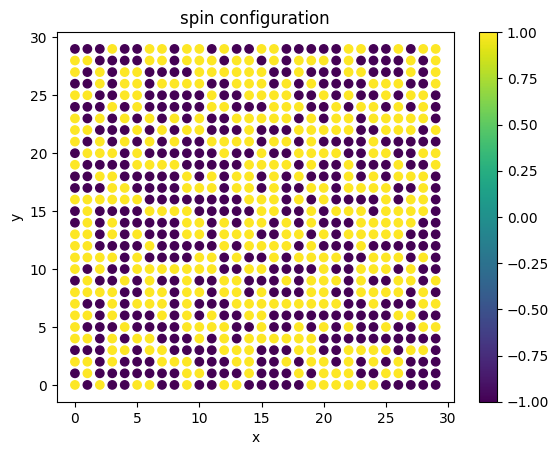

In [5]:
ising.plot_spin(ising.spin)

In [6]:
#Running Monte Carlo
ising.ising_driver()

In [7]:
#Extracting key quantities
ising.get_stats()

Total number of steps run = 2000.0
Acceptance ratio = 0.08374833333333333
Temperature = 2
<E/N> = -1.7314999999999998
<M/N> = 0.8793344444444444
specific heat = 1.5759748611111557
magnetic susceptibility = 4.240083110833334


In [8]:
ising.spin

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        -1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1,
        -1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1

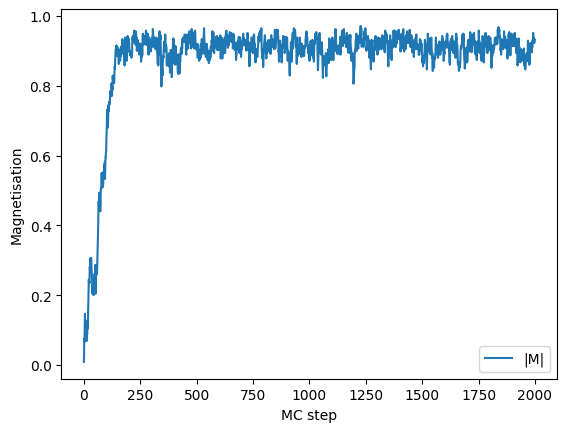

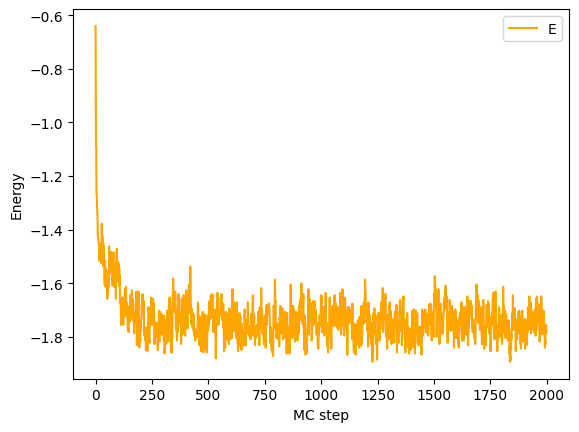

In [10]:
plt.ylabel('Magnetisation')
plt.xlabel('MC step')
plt.plot(np.abs(ising.data[:,1]/ising.N),'-',label='|M|')
plt.legend()
plt.show()
plt.close()
plt.ylabel('Energy')
plt.xlabel('MC step')
plt.plot(ising.data[:,0]/ising.N,'-',label='E',c='orange')
plt.legend()
plt.show()

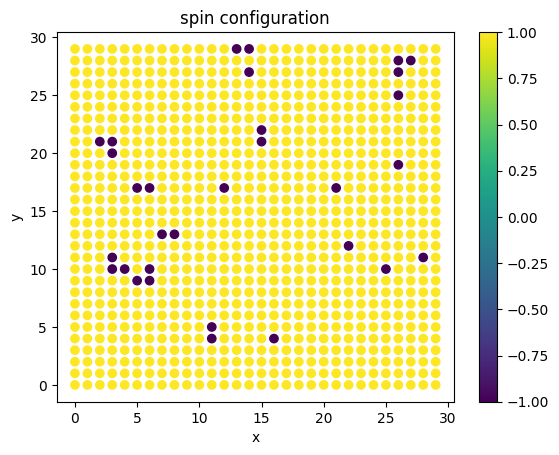

In [11]:
ising.plot_spin(ising.spin)

-----------------------------------

Now we increase the temperature to T=4.

Total number of steps run = 2000.0
Acceptance ratio = 0.6100044444444445
Temperature = 4
<E/N> = -0.5551266666666667
<M/N> = -0.0007644444444444443
specific heat = 0.17841576416666916
magnetic susceptibility = 0.25459546222222224


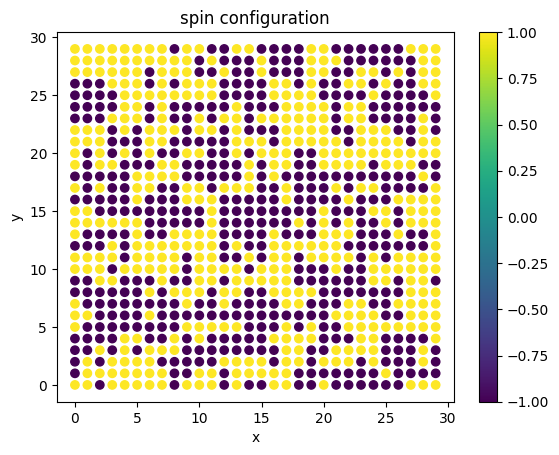

In [12]:
# lateral size L (N=LxL), temperature T, nequil, nmcas
ising = Ising(30,4,1000,1000,sample_equi=True)
ising.initialize()
ising.ising_driver()
ising.get_stats()
ising.plot_spin(ising.spin)

-------------------------

>There seems to be a phase transition between T=2 and T=4, let's investigate what happens as a function of temperature.

In [13]:
res=[]
T_list = np.linspace(1.5,4,10)
for T in T_list:
    ising = Ising(30,T,1000,1000,sample_equi=False)
    ising.initialize()
    ising.ising_driver()
    ising.get_stats()
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)


Total number of steps run = 2000.0
Acceptance ratio = 0.018533888888888888
Temperature = 1.5
<E/N> = -1.9506888888888887
<M/N> = 0.986331111111111
specific heat = 0.1757706666668808
magnetic susceptibility = 0.01645866469135163
Total number of steps run = 2000.0
Acceptance ratio = 0.04475222222222222
Temperature = 1.7777777777777777
<E/N> = -1.8705511111111113
<M/N> = 0.9606044444444444
specific heat = 0.37400694749985636
magnetic susceptibility = 0.053845335000019076
Total number of steps run = 2000.0
Acceptance ratio = 0.09907944444444444
Temperature = 2.0555555555555554
<E/N> = -1.705008888888889
<M/N> = 0.89312
specific heat = 0.6883804652738945
magnetic susceptibility = 0.19872923956172023
Total number of steps run = 2000.0
Acceptance ratio = 0.23376388888888888
Temperature = 2.3333333333333335
<E/N> = -1.3193422222222222
<M/N> = 0.5446533333333333
specific heat = 1.671281946122513
magnetic susceptibility = 4.12450217469388
Total number of steps run = 2000.0
Acceptance ratio = 0.3

In [ ]:
#np.savetxt('res_acc.txt',res)
#np.savetxt('T_acc.txt',T_list)

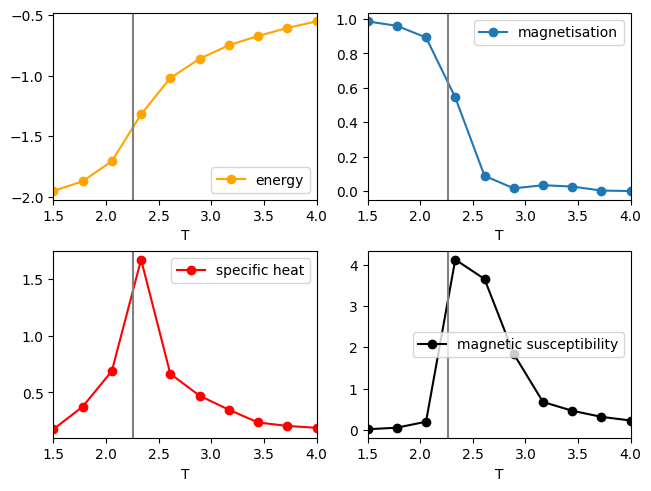

In [14]:
#plotting as a function of temperature
def plot_res(T_list,res):
    fig, axs = plt.subplots(ncols=2, nrows=2,layout="constrained")
    axs[0,0].plot(T_list,res[:,0],'o-',c='orange',label='energy')
    axs[0,1].plot(T_list,np.abs(res[:,1]),'o-',label='magnetisation')
    axs[1,0].plot(T_list,res[:,2],'o-',c='red',label='specific heat')
    axs[1,1].plot(T_list,res[:,3],'o-',c='k',label='magnetic susceptibility')
    for axx in axs:
        for ax in axx:
            ax.legend()
            ax.set_xlabel('T')
            ax.set_xlim([1.5,4])
            ax.axvline(x=2.26,c='grey')
plot_res(T_list,res)

>A proper sampling requires more computational time, let's load some results computed with this code for longer runs (10000 steps) and with a more dense sampling of temperatures.

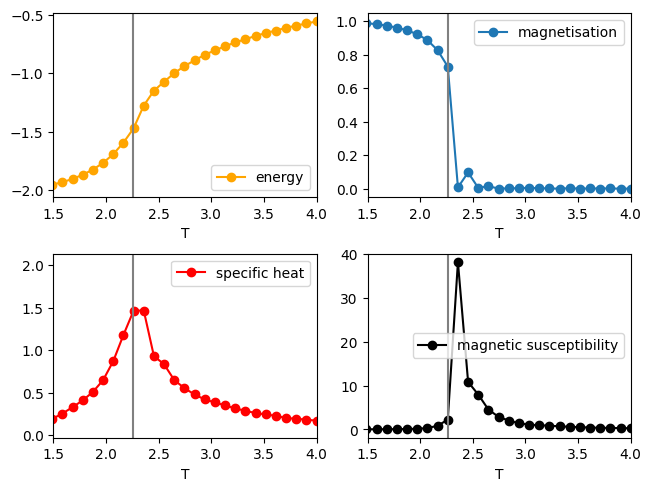

In [16]:
res = np.loadtxt('./res_acc.txt')
T_list = np.loadtxt('./T_acc.txt')
plot_res(T_list,res)

### Profiling
In the next lecture we will see how to make the code faster by integrating Fortran subroutines into Python code with *f2py*.\
For the moment, we will just investigate where the code spends most of the run time.

In [17]:
%load_ext line_profiler

In [18]:
ising = Ising(10,T,100,1000,sample_equi=False)
ising.initialize()
%lprun -f ising.ising_driver ising.ising_driver()

In [19]:
ising = Ising(10,T,100,1000,sample_equi=False)
ising.initialize()
%lprun -f ising.metro_step ising.ising_driver()